In [5]:
%%html

Page Links — <a href="index.html" target="_self">Project Overview Page</a>
— <a href="page1.html" target="_self">Dataset Page</a>
— <a href="page2.html" target="_self">Data Imputation Page</a>
— <a href="page3.html" target="_self">Data Exploration Page</a>
— <a href="page4.html" target="_self">Data Modeling Page</a>

In [2]:
# Toggle raw code on/off, from stackoverflow
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle raw code on/off"></form>''')

---

# Data Cleaning and Identification of Missing Data (and pre-Imputation)

**Prior to modeling, we need to analyze the dates that may be missing data for sales (e.g. store renovations). Visualizations and analyses will help us determine where and how to impute, which is show below.**

At first, we thought about various ways to determine where data for sales needed to be imputed. An immediate thought was where Sales == 0, but the logic here is flawed, as it is possible for a store not to have sales one day. Ultimately, using forums found on Kaggle's https://www.kaggle.com/nsecord/rossmann-store-sales/filling-gaps-in-the-training-set, we decided upon plotting number of stores operating versus date.

In [49]:
# create dates variable
traindate = train["Date"]

In [50]:
# sort all days, then create variable "dates" with each date listed once and sorted
dates_chronological = sorted(traindate, key=lambda x: datetime.datetime.strptime(x, '%m/%d/%y'))

dates = sorted(set(dates_chronological), key=lambda x: datetime.datetime.strptime(x, '%m/%d/%y'))

print "The data covers dates that span " + str(len(dates)) + " days."

The data covers dates that span 942 days.


Next, we want to count the frequency of each date in the data. This will indicate the number of operating stores. Plotting this (y-variable) against the date itself (x-variable) will reveal what timeframe the stores were not all operating. Note: it is given there are 1115 total stores.

In [51]:
# create list "nums" that counts how many stores are open each day, corresponds to dates indices
num_stores = []
for i in dates:
    num_stores.append(dates_chronological.count(i))

In [52]:
# convert dates variable to Python datetime format
date_python = [""]*len(dates)
for i in range(len(dates)):
    date_python[i] = time.strptime(dates[i], "%m/%d/%y")   

In [53]:
# numericize (temporarily) the dates
new_x = matplotlib.dates.datestr2num(dates)

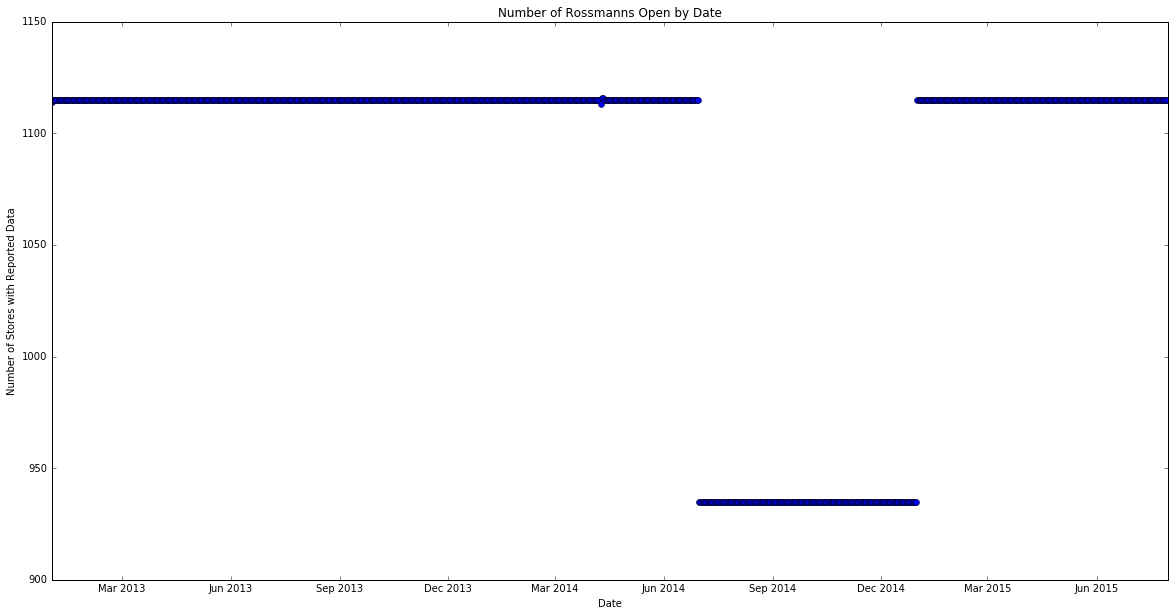

In [54]:
# column-combine dates and store counts
dates_num_stores = np.column_stack((dates, num_stores))

# plot stores operating with data versus date
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.plot_date(new_x, num_stores, fmt="bo", tz=None, xdate=True)
ax.set_title("Number of Rossmanns Open by Date")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Stores with Reported Data")

In [55]:
# confirm this anomaly by looking at number of stores before, during, and after this drop
### before anomaly
print "On June 1st, 2014, there were " + str(len(np.unique(train["Store"][train["Date"] == "6/1/14"]))) + " stores open and reporting data.\n"

### during anomaly
print "On July 1st, 2014, there were " + str(len(np.unique(train["Store"][train["Date"] == "7/1/14"]))) + " stores open and reporting data."
print "On December 31st, 2014, there were " + str(len(np.unique(train["Store"][train["Date"] == "12/31/14"]))) + " stores open and reporting data."
print "On January 1st, 2015, there were " + str(len(np.unique(train["Store"][train["Date"] == "1/1/15"]))) + " stores open and reporting data.\n"

### after anomaly
print "On March 1st, 2015, there were " + str(len(np.unique(train["Store"][train["Date"] == "3/1/15"]))) + " stores open and reporting data."

On June 1st, 2014, there were 1115 stores open and reporting data.

On July 1st, 2014, there were 935 stores open and reporting data.
On December 31st, 2014, there were 935 stores open and reporting data.
On January 1st, 2015, there were 1115 stores open and reporting data.

On March 1st, 2015, there were 1115 stores open and reporting data.


Thus, it appears we are missing data from 1115 - 935 = 180 stores, from July 1st 2014 to December 31st 2014 (7/1/14 - 12/31/14). With this information, we need to proceed by identifying which stores themselves are missing data. This will be done by seeing which stores are normally reporting data (all 1115 of them) and subtracting the stores reporting data during the anomaly period, like on October 15th, 2014 (08/15/15).

In [56]:
# find missing stores
allstores = np.unique(train["Store"])
stores_oct152015 = train["Store"][train["Date"] == "8/15/14"]
missing_stores = list(set(allstores) - set(stores_oct152015))

With all missing stores' indices saved in missing_stores, we need to address one more concern and begin our first imputation: the first value in num_stores, indicating New Year's Day of 2013, is 1114, which means one store was not open and not reporting data. This single problematic observation can be resolved rather simply. Since the same store was open on January 1st of 2014, both were weekdays, and there is no major reason to believe New Year's Day sales vary drastically year to year, we can impute the sales and customers from 2014 for 2013. 

In [57]:
# impute Sales for 1-1-13 for one store by identifying it first
stores_jan12013 = train["Store"][train["Date"] == "1/1/13"]
missing_store_jan12013 = list(set(allstores) - set(stores_jan12013))
print "The store missing data for January 1, 2013, is Store " + str(missing_store_jan12013[0]) + "."

The store missing data for January 1, 2013, is Store 988.


In [58]:
# impute its Sales from 1-1-14
temp_row = train[train["Store"] == 988]
temp_row = temp_row[temp_row["Date"] == "1/1/14"]
temp_row["DayOfWeek"] = temp_row["DayOfWeek"] - 1 # because year before means day of the week shifts back one day
temp_row["Date"] = "1/1/13"

In [59]:
# impute the information into train dataset, check if succesful
train = train.append(temp_row)
stores_jan12013 = train["Store"][train["Date"] == "1/1/13"]
missing_store_jan12013 = list(set(allstores) - set(stores_jan12013))
if(missing_store_jan12013 == []):
    print "The imputation was successful! No missing store data on 1/1/13. Data imputed from 1/1/14."
else:
    print "The imputation was unsuccessful."

The imputation was successful! No missing store data on 1/1/13. Data imputed from 1/1/14.


Now that we successfully and reasonably imputed the data for this one strange date, we can direct our attention towards imputing data for the range of dates spanning 7/1/14 through the end of the calendar year of 2014, 12/31/14. We will start this process by simply imputing for one store (perhaps the smallest numbered store, Store 13) and then repeating this action for all stores in missing_stores.

**Regarding the variability of Sales:** Due to the volatile nature of sales, per the class-provided webpage https://www.kaggle.com/nsecord/rossmann-store-sales/filling-gaps-in-the-training-set/, we think it is best to work with natural log of sales during imputation, then converting it back to normal sales. A column for logsales is appended to dataframe train below.

Note: In order to account for the 0 Sales days, we cannot simply log the sales since the 0 sales days will be ignored. Instead, we had to uniquely transform Sales via the following method: log (x + 1), so that 0 maps to 0!

In [60]:
# add logsales to train dataset
train["LogSales"] = np.log(np.add(train["Sales"], 1))
# find lowest numbered missing store to practice imputations on
print "The store that is missing data in the anomaly period with the lowest titled number is Store " + str(min(missing_stores))

The store that is missing data in the anomaly period with the lowest titled number is Store 13


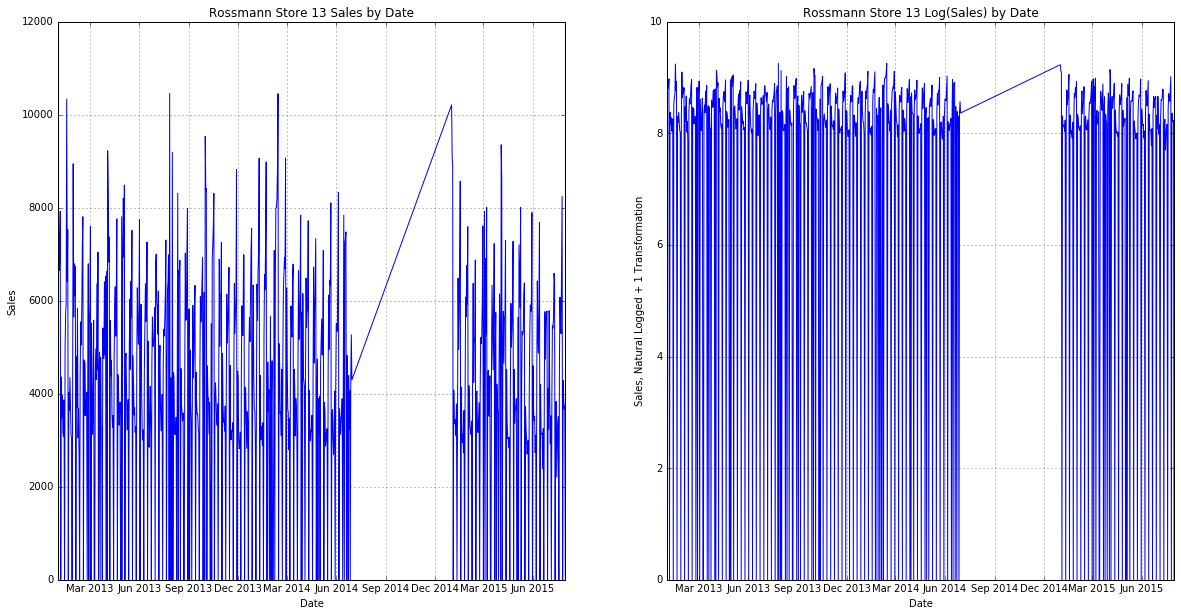

In [61]:
# observe sales and log(sales) of Store 13 versus date, verify our decision to use log
# prepare x and y's for plot
### numericize (temporarily) the dates
dates_ = list(set(train["Date"][train["Store"] == 13]))
dates_chronological_ = sorted(dates_, key=lambda x: datetime.datetime.strptime(x, '%m/%d/%y'))
dates_ = sorted(set(dates_chronological_), key=lambda x: datetime.datetime.strptime(x, '%m/%d/%y'))
new_x = matplotlib.dates.datestr2num(dates_)

# plot
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,2,1)
ax.plot_date(new_x, train["Sales"][train["Store"] == 13], fmt="b-", tz=None, xdate=True)
ax.set_title("Rossmann Store 13 Sales by Date")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.grid(True)
axlog = fig.add_subplot(1,2,2)
axlog.plot_date(new_x, train["LogSales"][train["Store"] == 13], fmt="b-", tz=None, xdate=True)
axlog.set_title("Rossmann Store 13 Log(Sales) by Date")
axlog.set_xlabel("Date")
axlog.set_ylabel("Sales, Natural Logged + 1 Transformation")
axlog.grid(True)

From the above, we see our transformation caused a strangely long plot of the log sales vs date, but reduced volatility at the peaks. Ultimately, we think this will help improve our imputations. 

# Data Imputation of "Anomaly" Period

Our method of imputation will be the following: We know our missing time period is from 7/1/14 through 12/31/14. The frequency of 0 Sales dates are likely due to particular days, like holidays, etc. As a result of this, we will cross reference the same time period in  2013 and match 0 Sales dates with each other for each Store ID, imputing 0 sales for the same date in 2014. For dates with actual positive sales, we will develop a method of imputation that takes into account the day of the week, store ID, presence of a promotion, and customers that visited the store.

Note: The data for date 1/1/13 was already imputed in the previous part.

In [62]:
# create empty storage variables, per Kaggle link https://www.kaggle.com/nsecord/rossmann-store-sales/filling-gaps-in-the-training-set/comments
# date range storage from http://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python

dates_anomaly = []

start = datetime.datetime.strptime("7/1/14", "%m/%d/%y")
end = datetime.datetime.strptime("1/1/15", "%m/%d/%y")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

for date in date_generated:
    dates_anomaly.append(date.strftime("%-m/%-d/%y"))


n_missing = len(dates_anomaly)*len(missing_stores)
empty_frame = pd.DataFrame(columns=list(train.columns.values))
empty_frame["Date"] = dates_anomaly*len(missing_stores)
empty_frame.head(n=5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,LogSales
0,NaN,NaN,7/1/14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,7/2/14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,7/3/14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,7/4/14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,7/5/14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are largely concerned with imputing the Sales (and LogSales) and Customers; for other information like Promo, Open, State & School Holiday, we will rely on majority vote of other data-reporting stores on the same date. 

In [63]:
for day in dates_anomaly:
    empty_frame["Store"][empty_frame["Date"] == day] = missing_stores
    
    day_of_week = np.unique(train["DayOfWeek"][train["Date"] == day])[0]
    empty_frame['DayOfWeek'][empty_frame["Date"] == day] = [day_of_week]*len(missing_stores)
    
    # do nothing for Sales yet, already NaNs
    
    # do nothing for Customers yet, already NaNs
    
    open_ = Counter(train["Open"][train["Date"] == day]).most_common(1)[0][0]
    empty_frame['Open'][empty_frame["Date"] == day] = [open_]*len(missing_stores)
    
    promo_ = Counter(train["Promo"][train["Date"] == day]).most_common(1)[0][0]
    empty_frame['Promo'][empty_frame["Date"] == day] = [promo_]*len(missing_stores)
    
    sth_ = Counter(train["StateHoliday"][train["Date"] == day]).most_common(1)[0][0]
    empty_frame['StateHoliday'][empty_frame["Date"] == day] = [sth_]*len(missing_stores)
    
    sch_ = Counter(train["SchoolHoliday"][train["Date"] == day]).most_common(1)[0][0]
    empty_frame['SchoolHoliday'][empty_frame["Date"] == day] = [sch_]*len(missing_stores)
    
    # do nothing for LogSales yet, already NaNs

In [64]:
print "The head of the empty dataset, prepped for imputation, is the following: "
empty_frame.head(n=6)

The head of the empty dataset, prepped for imputation, is the following: 


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,LogSales
0,512,2,7/1/14,NaN,NaN,1,1,0,0,NaN
1,512,3,7/2/14,NaN,NaN,1,1,0,0,NaN
2,512,4,7/3/14,NaN,NaN,1,1,0,0,NaN
3,512,5,7/4/14,NaN,NaN,1,1,0,0,NaN
4,512,6,7/5/14,NaN,NaN,1,0,0,0,NaN
5,512,7,7/6/14,NaN,NaN,0,0,0,0,NaN


In [65]:
# impute some of the Sales, Customers, and LogSales using Open
len_empty = np.shape(empty_frame)[0]

for i in range(len_empty):
    if (empty_frame.loc[i, ["Open"]][0] == 0):
        empty_frame.set_value(i, 'Sales', 0)
        empty_frame.set_value(i, 'Customers', 0)
        empty_frame.set_value(i, 'LogSales', 0)   ####NOTE: this part works

In [66]:
### Impute all Open == 1 Sales using conditioned median

#Determine pivot table - from https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/
imputation = train.pivot_table(values=["Sales"], index=["Store","DayOfWeek","Promo"], aggfunc=np.median)
imputation

# from https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/
for i, row in empty_frame.loc[empty_frame['Sales'].isnull(),:].iterrows():
    ind = tuple([row['Store'],row['DayOfWeek'],row['Promo']])
    empty_frame.loc[i,'Sales'] = imputation.loc[ind].values[0]

In [67]:
### Impute all Open == 1 Customers using conditioned median

#Determine pivot table - from https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/
imputation = train.pivot_table(values=["Customers"], index=["Store","DayOfWeek","Promo"], aggfunc=np.median)
imputation

for i, row in empty_frame.loc[empty_frame['Customers'].isnull(),:].iterrows():
    ind = tuple([row['Store'],row['DayOfWeek'],row['Promo']])
    empty_frame.loc[i,'Customers'] = imputation.loc[ind].values[0]

In [68]:
### Impute all Open == 1 LogSales using conditioned median

#Determine pivot table - from https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/
imputation = train.pivot_table(values=["LogSales"], index=["Store","DayOfWeek","Promo"], aggfunc=np.median)
imputation

for i, row in empty_frame.loc[empty_frame['LogSales'].isnull(),:].iterrows():
    ind = tuple([row['Store'],row['DayOfWeek'],row['Promo']])
    empty_frame.loc[i,'LogSales'] = imputation.loc[ind].values[0]

In [69]:
# view all NaN data, now imputed completely!
empty_frame

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,LogSales
0,512,2,7/1/14,5398,1302,1,1,0,0,8.59397
1,512,3,7/2/14,5497,1303,1,1,0,0,8.61214
2,512,4,7/3/14,5495,1327,1,1,0,0,8.61178
3,512,5,7/4/14,5982,1502,1,1,0,0,8.69668
4,512,6,7/5/14,4325,1036.5,1,0,0,0,8.3724
5,512,7,7/6/14,0,0,0,0,0,0,0
6,512,1,7/7/14,4928.5,1290.5,1,0,0,0,8.50299
7,512,2,7/8/14,4798,1241,1,0,0,0,8.47616
8,512,3,7/9/14,4725,1222,1,0,0,0,8.46083
9,512,4,7/10/14,5057.5,1253.5,1,0,0,0,8.5288


In [70]:
# append "imputed" frame to train dataset
train = train.append(empty_frame)

In [85]:
# view completed imputation
train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,LogSales,Year,Month,Day
0,1,5,7/31/15,5263,555,1,1,0,1,8.56865,2015,7,1/15
1,2,5,7/31/15,6064,625,1,1,0,1,8.71029,2015,7,1/15
2,3,5,7/31/15,8314,821,1,1,0,1,9.02582,2015,7,1/15
3,4,5,7/31/15,13995,1498,1,1,0,1,9.54653,2015,7,1/15
4,5,5,7/31/15,4822,559,1,1,0,1,8.48115,2015,7,1/15
5,6,5,7/31/15,5651,589,1,1,0,1,8.63976,2015,7,1/15
6,7,5,7/31/15,15344,1414,1,1,0,1,9.63854,2015,7,1/15
7,8,5,7/31/15,8492,833,1,1,0,1,9.047,2015,7,1/15
8,9,5,7/31/15,8565,687,1,1,0,1,9.05556,2015,7,1/15
9,10,5,7/31/15,7185,681,1,1,0,1,8.87989,2015,7,1/15


# Loading the Imputed Dataset

In [4]:
# range for all but first column
cols = range(1,11)

# convert to datetime foramt
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%y')

# load the imputed train set
imputed_0 = pd.read_csv('out-000.csv', parse_dates=['Date'], date_parser=dateparse)
imputed_1 = pd.read_csv('out-001.csv', parse_dates=['Date'], date_parser=dateparse)
imputed_2 = pd.read_csv('out-002.csv', parse_dates=['Date'], date_parser=dateparse)
imputed_3 = pd.read_csv('out-003.csv', parse_dates=['Date'], date_parser=dateparse)
imputed_4 = pd.read_csv('out-004.csv', parse_dates=['Date'], date_parser=dateparse)
imputed_5 = pd.read_csv('out-005.csv', parse_dates=['Date'], date_parser=dateparse)

# merge them together
combined = [imputed_0, imputed_1, imputed_2, imputed_3, imputed_4, imputed_5]
imputed = pd.concat(combined)

train = imputed
train.head()

C:\Users\lukak\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,LogSales
0,0,1,5,2015-07-31,5263.0,555.0,1,1,0,1,8.568646
1,1,2,5,2015-07-31,6064.0,625.0,1,1,0,1,8.710290
2,2,3,5,2015-07-31,8314.0,821.0,1,1,0,1,9.025816
3,3,4,5,2015-07-31,13995.0,1498.0,1,1,0,1,9.546527
4,4,5,5,2015-07-31,4822.0,559.0,1,1,0,1,8.481151


---

In [6]:
%%html

Page Links — <a href="index.html" target="_self">Project Overview Page</a>
— <a href="page1.html" target="_self">Dataset Page</a>
— <a href="page2.html" target="_self">Data Imputation Page</a>
— <a href="page3.html" target="_self">Data Exploration Page</a>
— <a href="page4.html" target="_self">Data Modeling Page</a>